In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard library imports
import sys
import os
import json

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set pandas display options
pd.set_option("display.max_rows", 200)

# Define file location
PY_FILE_LOC = os.getcwd()

# Project-specific utility imports
from utils.savefig import savefig_template
from utils.nbutils_corr import (
    vars_iv_rename_cols,
    plot_corr_matrix_with_p_values,
    set_splits,
    plot_growth_rate,
	get_correl_type_from_title
)
from utils.nbutils_load_data import load_and_process_data


In [3]:
# load the config
config_fn = os.path.join(PY_FILE_LOC, "config.json")
if os.path.exists(config_fn):
    with open(config_fn) as config_file:
        config = json.load(config_file)
else:
    config = dict()

# figure save
SAVE_FLAG = bool(config.get("save_figure"))
FIG_BASE_FOLDER = os.path.join(PY_FILE_LOC, "fig")
if not os.path.exists(FIG_BASE_FOLDER):
    os.mkdir(FIG_BASE_FOLDER)

def savefig(fig, fn, **kwargs):
    return savefig_template(SAVE_FLAG, FIG_BASE_FOLDER, fig, fn, **kwargs)

In [4]:
# load the processed dataset
ftr_pref_muni = ["pref", "muni"]
folder = os.path.join(PY_FILE_LOC, "data")
pv_params, df = load_and_process_data(folder)
print(pv_params.filter(regex="^land_").sum().div(1_000_000))
print(pv_params.columns)
print(df.columns)

land_total        37.295617
land_habitable    12.293681
land_buildings     1.746126
land_agri          4.325727
land_avail         6.221828
dtype: float64
Index(['pref', 'muni', 'demand', 'land_total', 'land_habitable',
       'land_buildings', 'land_agri', 'taxable_income', 'LV', 'LV_2014',
       'LV_2015', 'LV_2016', 'LV_2017', 'LV_2018', 'LV_2019', 'LV_2020',
       'LV_2021', 'LV_2022', 'LV_2023', 'PV_R_2014', 'PV_R_2015', 'PV_R_2016',
       'PV_R_2017', 'PV_R_2018', 'PV_R_2019', 'PV_R_2020', 'PV_R_2021',
       'PV_R_2022', 'PV_R_2023', 'PV_S_2014', 'PV_S_2015', 'PV_S_2016',
       'PV_S_2017', 'PV_S_2018', 'PV_S_2019', 'PV_S_2020', 'PV_S_2021',
       'PV_S_2022', 'PV_S_2023', 'PV_M_2014', 'PV_M_2015', 'PV_M_2016',
       'PV_M_2017', 'PV_M_2018', 'PV_M_2019', 'PV_M_2020', 'PV_M_2021',
       'PV_M_2022', 'PV_M_2023', 'PV_U_2014', 'PV_U_2015', 'PV_U_2016',
       'PV_U_2017', 'PV_U_2018', 'PV_U_2019', 'PV_U_2020', 'PV_U_2021',
       'PV_U_2022', 'PV_U_2023', 'pv_out', 'epco', 

In [5]:
# total capacity per category
pv_cap_summary = []
for year in range(2014, 2024):
    df_temp = pv_params.filter(regex=rf"^PV_.*_{year}$").sum().to_frame(year)
    df_temp.index = ["_".join(c.split("_")[:2]) for c in df_temp.index]
    pv_cap_summary.append(df_temp.copy())
pv_cap_summary = pd.concat(pv_cap_summary, axis=1).div(1_000_000).round(4)
pv_cap_summary

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
PV_R,7.1140,7.9915,8.8137,9.4633,10.1084,11.0258,11.7721,12.6144,13.6435,14.6023
PV_S,5.1821,8.4404,10.4761,12.1203,13.5517,15.1281,16.4770,17.4159,17.9928,18.3350
PV_M,3.4968,5.1632,6.4111,7.2256,7.8585,8.5172,9.2336,9.7413,10.1944,10.5437
PV_U,4.0835,7.9201,10.6694,13.3674,15.8983,18.0204,21.7944,24.0094,26.4786,28.5135
PV_A,19.8764,29.5153,36.3703,42.1766,47.4168,52.6916,59.2771,63.7811,68.3093,71.9945


In [6]:
# national share
national_share = (100 * pv_cap_summary.iloc[:4] / pv_cap_summary.iloc[:4].sum()).round(
    2
)
national_share

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
PV_R,35.79,27.08,24.23,22.44,21.32,20.93,19.86,19.78,19.97,20.28
PV_S,26.07,28.60,28.80,28.74,28.58,28.71,27.80,27.31,26.34,25.47
PV_M,17.59,17.49,17.63,17.13,16.57,16.16,15.58,15.27,14.92,14.65
PV_U,20.54,26.83,29.34,31.69,33.53,34.20,36.77,37.64,38.76,39.61


In [7]:
pv_params[['muni', 'PV_A_2023']].sort_values('PV_A_2023', ascending=False).head()

,muni,PV_A_2023
950,浜松市,667879.0
1038,津市,488671.0
1631,宮崎市,474588.0
1613,大分市,401322.0
1156,姫路市,392562.0


In [8]:
pv_params[['muni', 'PV_R_2023']].sort_values('PV_R_2023', ascending=False).head()

,muni,PV_R_2023
984,名古屋市,179390.0
950,浜松市,161435.0
689,横浜市,134575.0
949,静岡市,110141.0
1568,熊本市,107446.0


In [9]:
pv_params[['muni', 'PV_S_2023']].sort_values('PV_S_2023', ascending=False).head()

,muni,PV_S_2023
950,浜松市,226312.0
475,前橋市,139621.0
1038,津市,129813.0
1303,岡山市,127164.0
476,高崎市,126070.0


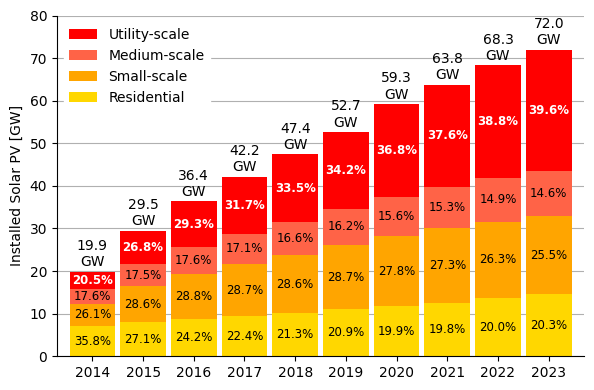

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.tight_layout()

colors = ["gold", "orange", "tomato", "red"]

pv_cap_summary.iloc[:4].T.plot(
    ax=ax, kind="bar", stacked=True, color=colors, width=0.9
)

for x, y in pv_cap_summary.loc["PV_A"].items():
    x = x - 2014
    ax.text(x, y + 0.5, f"{round(y, 1)}\nGW", ha="center", va="bottom")

fmt_common = dict(ha="center", va="center", fontsize=8.5)

for col in pv_cap_summary.columns:
    x = col - 2014
    pv_r = pv_cap_summary[col]["PV_R"]
    pv_s = pv_cap_summary[col]["PV_S"]
    pv_m = pv_cap_summary[col]["PV_M"]
    pv_u = pv_cap_summary[col]["PV_U"]

    ax.text(x, pv_r / 2, f'{round(national_share[col]["PV_R"], 1)}%', color="k", **fmt_common)
    ax.text(x, pv_r + (pv_s / 2), f'{round(national_share[col]["PV_S"], 1)}%', color="k", **fmt_common)
    ax.text(x, pv_r + pv_s +(pv_m / 2), f'{round(national_share[col]["PV_M"], 1)}%', color="k", **fmt_common)
    ax.text(x, pv_r + pv_s + pv_m + (pv_u / 2), f'{round(national_share[col]["PV_U"], 1)}%', color="w", **fmt_common, fontweight='bold')

ax.set_ylim(0, 80)
ax.set_ylabel('Installed Solar PV [GW]')

ax.tick_params(axis='x', rotation=0)

ax.grid(axis="y")
ax.set_axisbelow(True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
new_labels = ["Residential", "Small-scale", "Medium-scale", "Utility-scale"]
ax.legend(handles=handles[::-1], labels=new_labels[::-1], edgecolor='white', framealpha=1)
;

savefig(fig, 'solar_pv_growth.svg')

In [11]:
pv_cap_summary.iloc[:4] / pv_cap_summary.iloc[:4].sum()

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
PV_R,0.357912,0.270759,0.242332,0.224373,0.213181,0.209252,0.198594,0.197777,0.199731,0.202825
PV_S,0.260716,0.285968,0.288040,0.287370,0.285799,0.287107,0.277966,0.273058,0.263402,0.254672
PV_M,0.175927,0.174934,0.176273,0.171318,0.165732,0.161643,0.155770,0.152730,0.149239,0.146451
PV_U,0.205445,0.268340,0.293355,0.316939,0.335288,0.341998,0.367670,0.376435,0.387628,0.396051


In [12]:
# available land is defined as the remaining habitable land after the land from buildings and agriculture were removed.
pv_params["land_avail"] = (
    pv_params["land_habitable"] - pv_params["land_buildings"] - pv_params["land_agri"]
)
pv_params.filter(regex="^land_").sum().div(1_000_000)

land_total        37.295617
land_habitable    12.293681
land_buildings     1.746126
land_agri          4.325727
land_avail         6.221828
dtype: float64

## Comparison of the Average Growth of Solar PV per Prefecture (2014-2023)

In [13]:
pv_cols = dict()
pv_types = ["PV_R", "PV_S", "PV_M", "PV_U"]
for pv_type in pv_types:
    pv_cols[pv_type] = pv_params.filter(regex=f"^{pv_type}").columns.tolist()

Japan Mean PCT Change: 0.08332877178855
Prefecture Mean PCT Change: 0.08206658571505428
Prefecture Std PCT Change: 0.010970467195177417


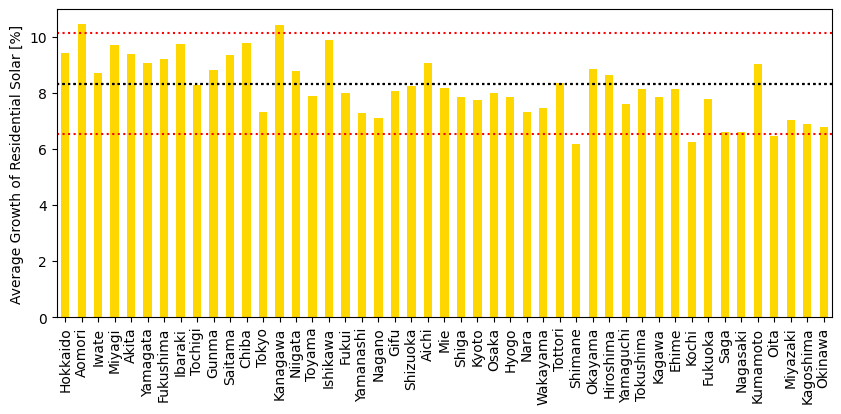

In [14]:
fig, ax = plot_growth_rate(
    pv_params,
    pv_cols["PV_R"],
    ylim=None,
    ylabel="Average Growth of Residential Solar [%]",
	barcolor='gold'
)

savefig(fig, f"eda_mean_growth_residential.svg")

Japan Mean PCT Change: 0.16217793675365644
Prefecture Mean PCT Change: 0.16230397674411787
Prefecture Std PCT Change: 0.04802268509483998


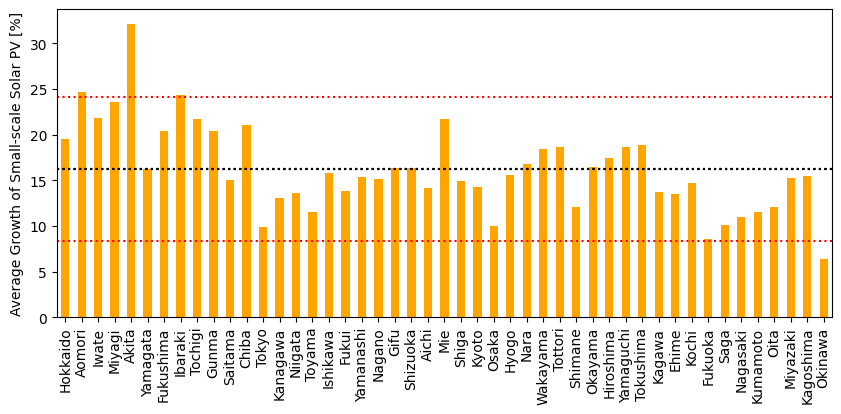

In [15]:
fig, ax = plot_growth_rate(
    pv_params,
    pv_cols["PV_S"],
    ylim=None,
    ylabel="Average Growth of Small-scale Solar PV [%]",
	barcolor='orange'
)

savefig(fig, f"eda_mean_growth_small.svg")

Japan Mean PCT Change: 0.13739431103534672
Prefecture Mean PCT Change: 0.13374385930963092
Prefecture Std PCT Change: 0.03570517405615616


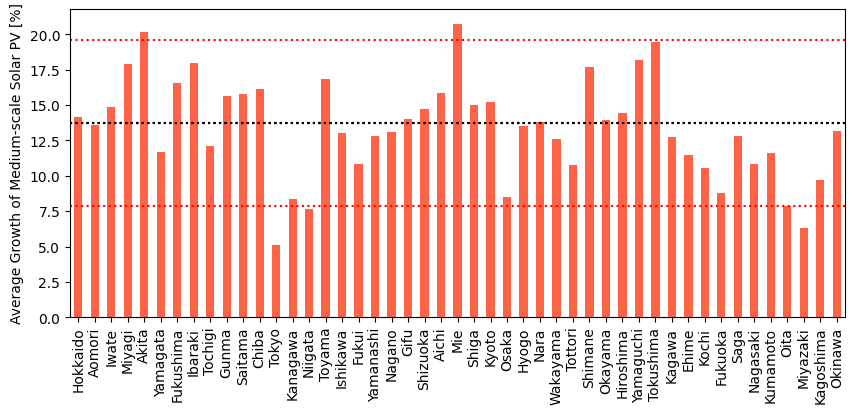

In [16]:
fig, ax = plot_growth_rate(
    pv_params,
    pv_cols["PV_M"],
    ylim=None,
    ylabel="Average Growth of Medium-scale Solar PV [%]",
	barcolor='tomato'
)

savefig(fig, f"eda_mean_growth_medium.svg")

Japan Mean PCT Change: 0.2614581136207599
Prefecture Mean PCT Change: 0.2708799216175318
Prefecture Std PCT Change: 0.09898239671877448


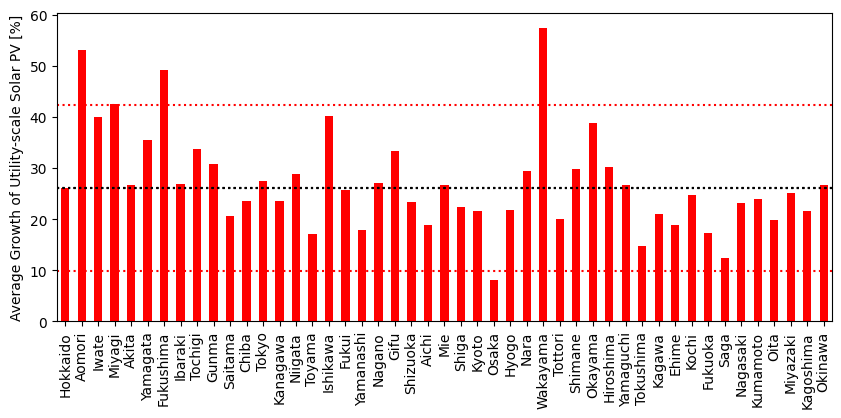

In [17]:
fig, ax = plot_growth_rate(
    pv_params,
    pv_cols["PV_U"],
    ylim=None,
    ylabel="Average Growth of Utility-scale Solar PV [%]",
	barcolor='red'
)

savefig(fig, f"eda_mean_growth_utility.svg")

## Correlation of the Capacity per Year

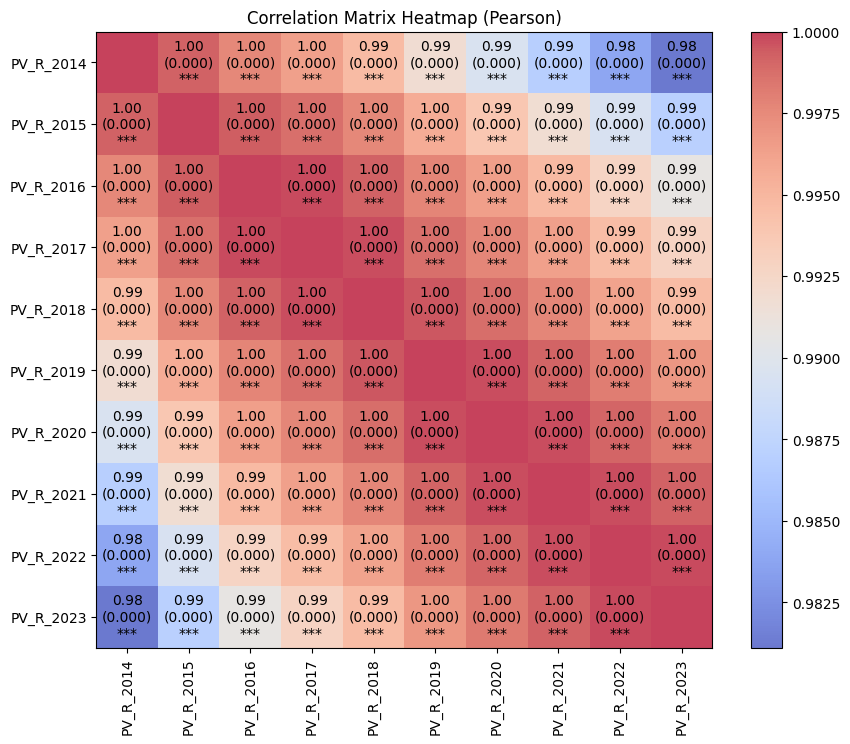

In [18]:
fig, ax = plot_corr_matrix_with_p_values(pv_params[pv_cols["PV_R"]])

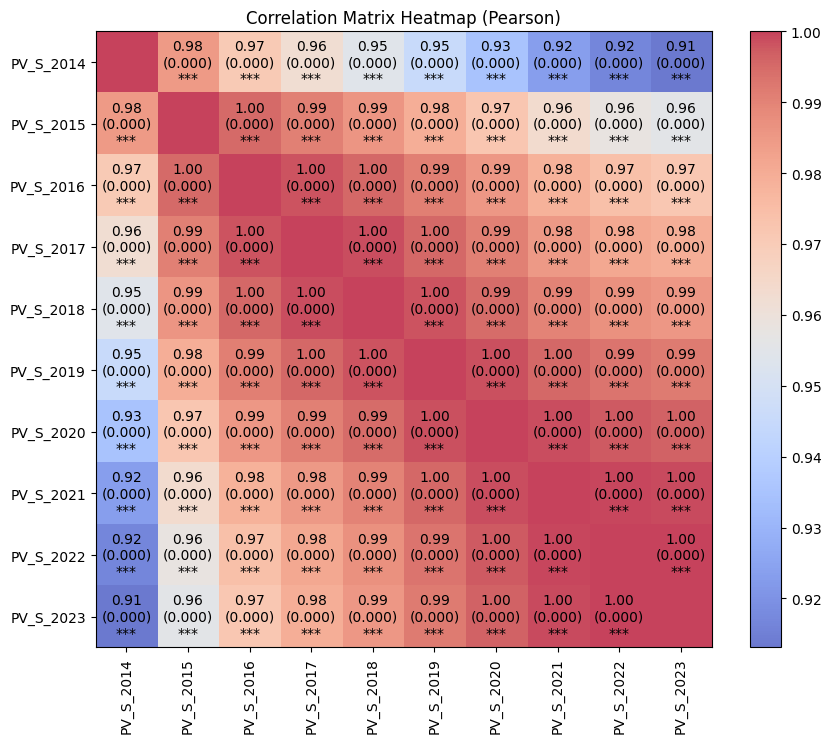

In [19]:
fig, ax = plot_corr_matrix_with_p_values(pv_params[pv_cols["PV_S"]])

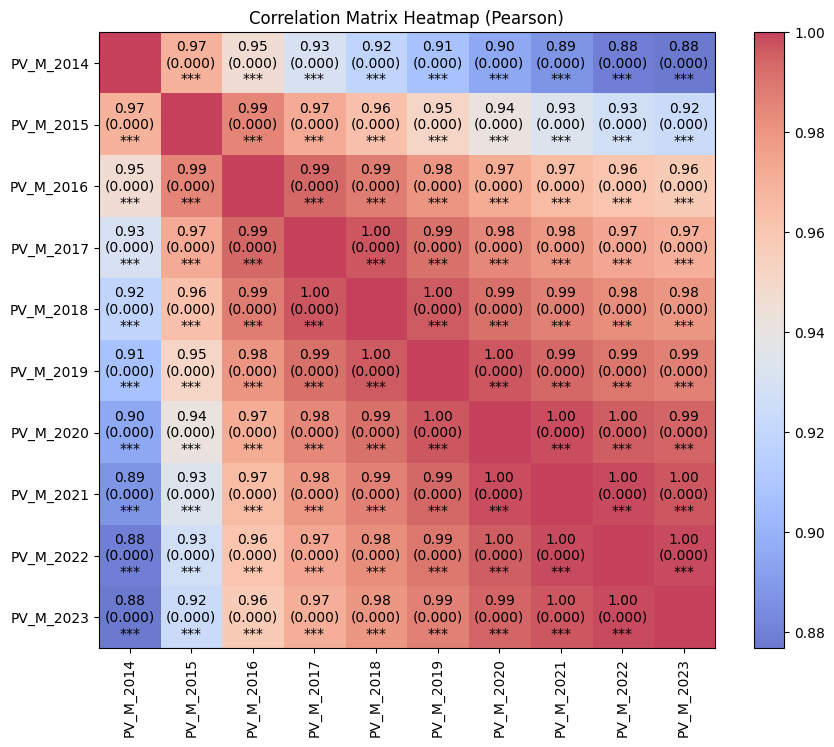

In [20]:
fig, ax = plot_corr_matrix_with_p_values(pv_params[pv_cols["PV_M"]])

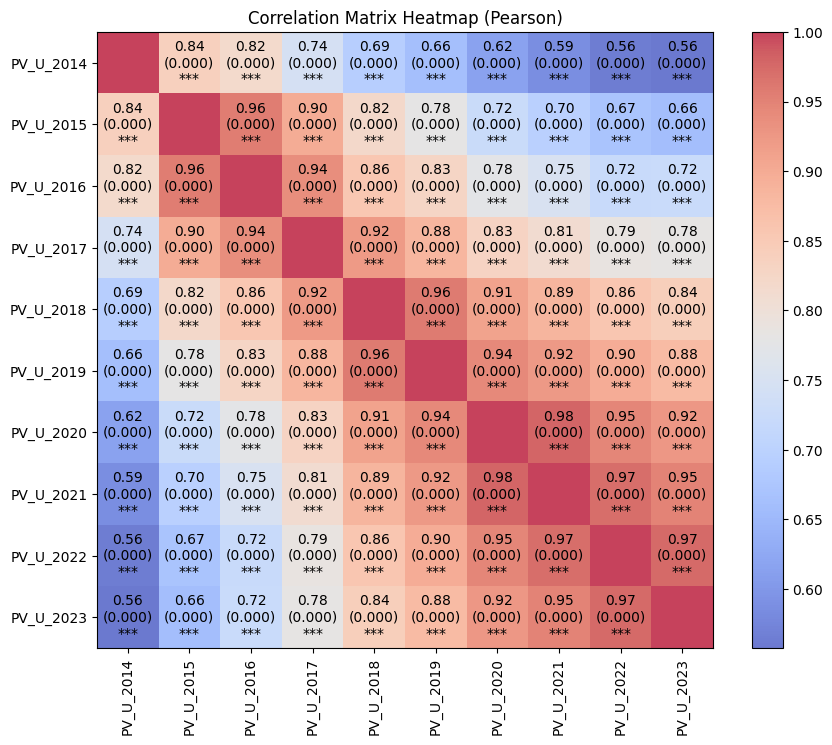

In [21]:
fig, ax = plot_corr_matrix_with_p_values(pv_params[pv_cols["PV_U"]])

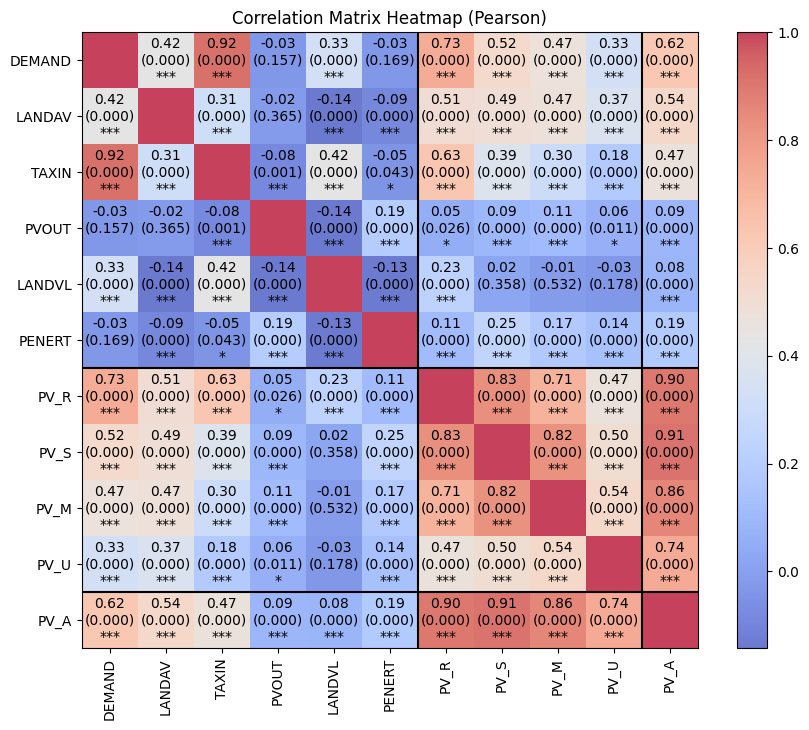

In [22]:
# Pearson Correlation for 2014
year = 2014
df_temp = df[df["year"] == year].set_index(ftr_pref_muni).drop("year", axis=1)
df_temp = df_temp.rename(columns=vars_iv_rename_cols)

fig, ax = plot_corr_matrix_with_p_values(df_temp)
set_splits(ax, [5.5, 9.5])

# save to file
title = ax.get_title()
correl_type = get_correl_type_from_title(ax)
ax.set_title(None)
savefig(fig, f"eda_{correl_type}_{year}.svg")
ax.set_title(title);

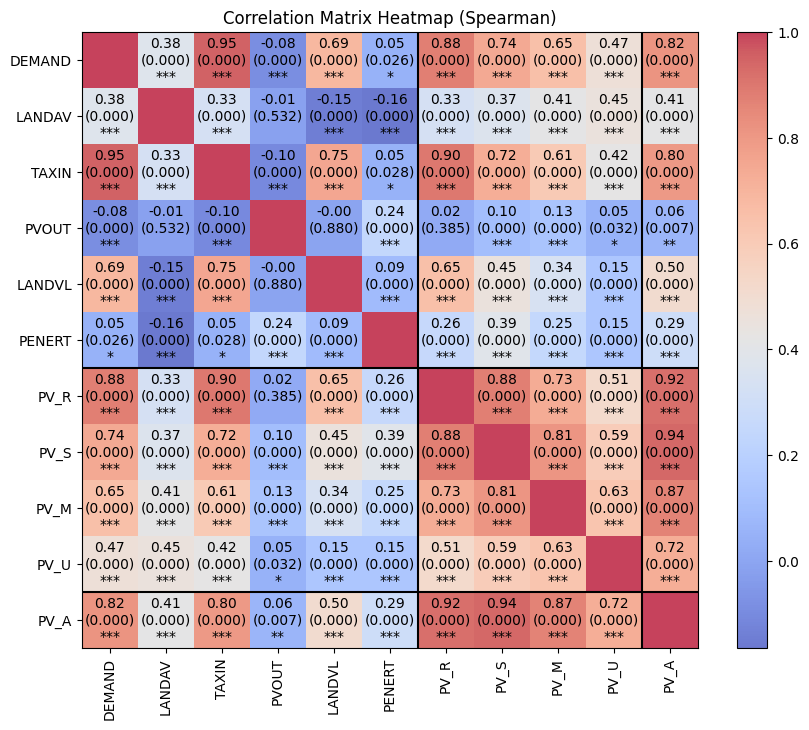

In [23]:
# Spearman Correlation for 2014
year = 2014
df_temp = df[df["year"] == year].set_index(ftr_pref_muni).drop("year", axis=1)
df_temp = df_temp.rename(columns=vars_iv_rename_cols)
fig, ax = plot_corr_matrix_with_p_values(df_temp, method="spearman")
set_splits(ax, [5.5, 9.5])

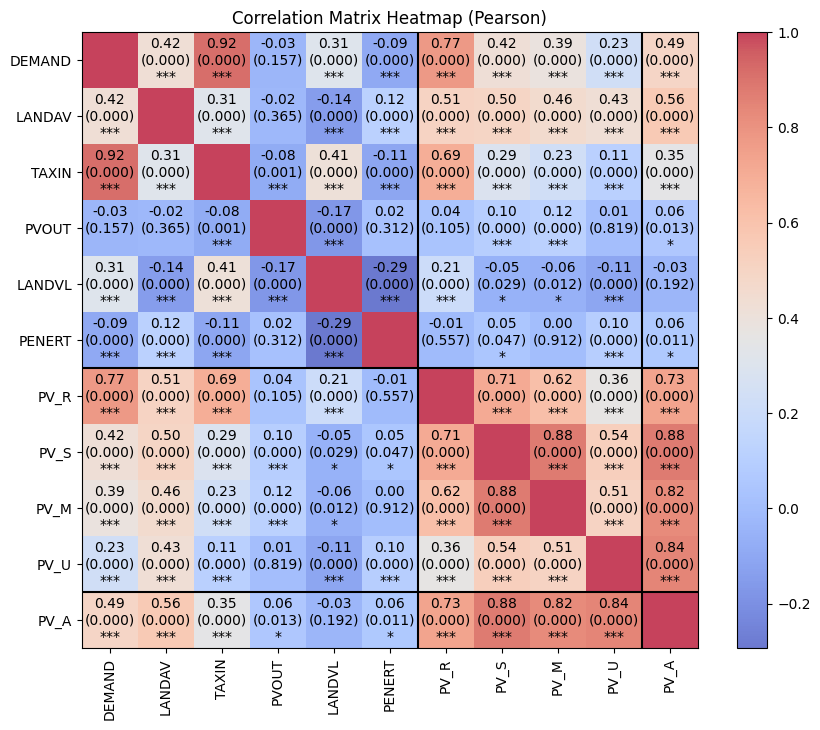

In [24]:
# Pearson Correlation for 2023
year = 2023
df_temp = df[df["year"] == year].set_index(ftr_pref_muni).drop("year", axis=1)
df_temp = df_temp.rename(columns=vars_iv_rename_cols)
fig, ax = plot_corr_matrix_with_p_values(df_temp)
set_splits(ax, [5.5, 9.5])

correl_type = get_correl_type_from_title(ax)
ax.set_title(None)
savefig(fig, f"eda_{correl_type}_{year}.svg")
ax.set_title(title);

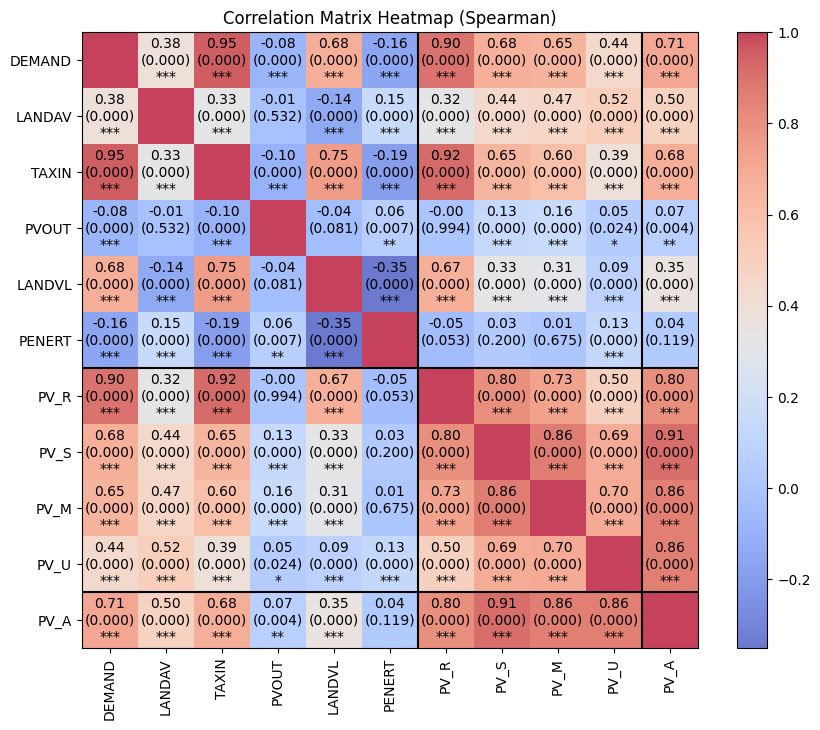

In [25]:
# Spearman Correlation for 2023
year = 2023
df_temp = df[df["year"] == year].set_index(ftr_pref_muni).drop("year", axis=1)
df_temp = df_temp.rename(columns=vars_iv_rename_cols)
fig, ax = plot_corr_matrix_with_p_values(df_temp, method="spearman")
set_splits(ax, [5.5, 9.5])

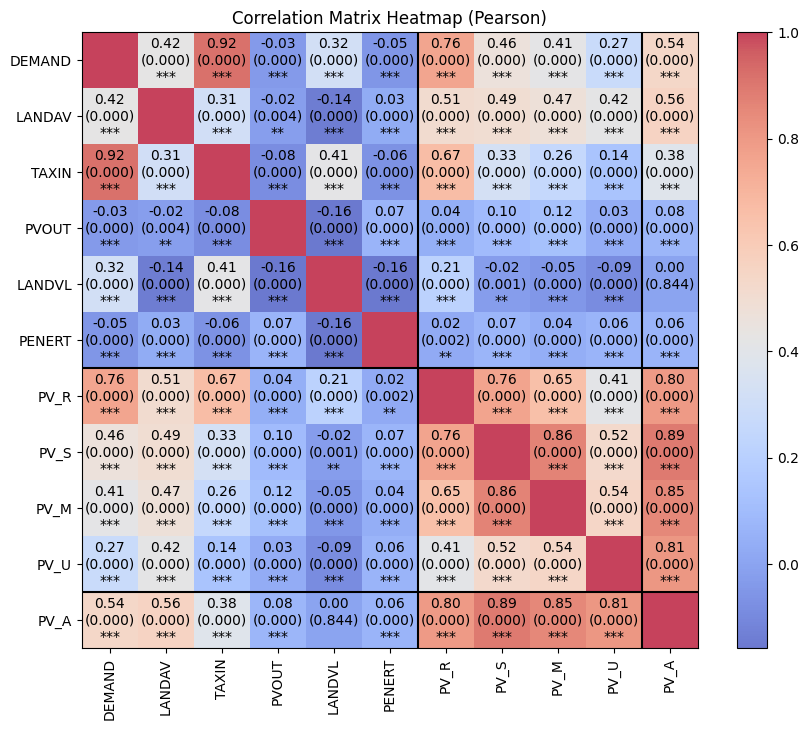

In [26]:
# Pearson Correlation using the 10 year data
df_temp = df.set_index(ftr_pref_muni).drop("year", axis=1)
df_temp = df_temp.rename(columns=vars_iv_rename_cols)
fig, ax = plot_corr_matrix_with_p_values(df_temp)
set_splits(ax, [5.5, 9.5])

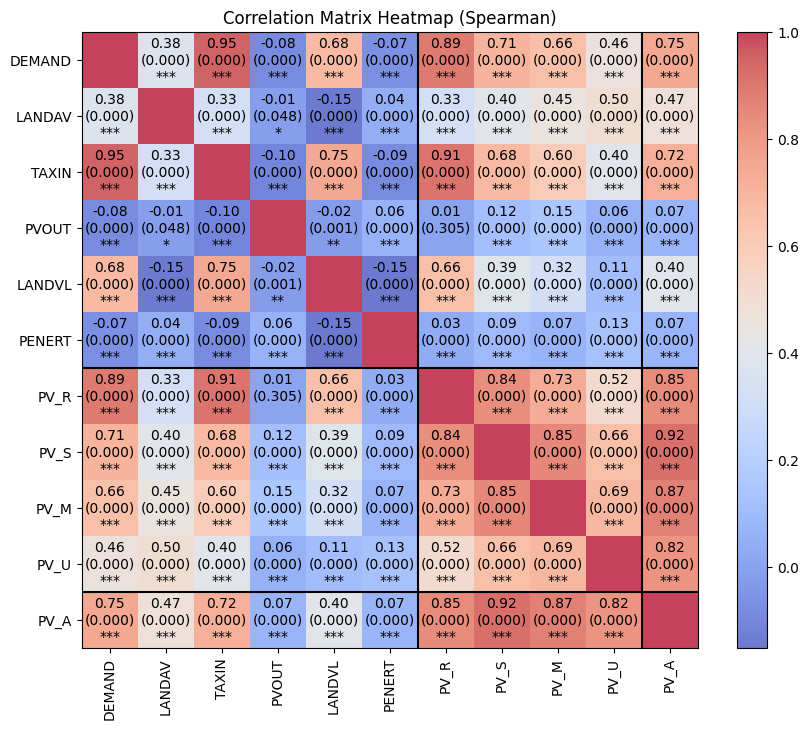

In [27]:
# Spearman Correlation using the 10 year data
df_temp = df.set_index(ftr_pref_muni).drop("year", axis=1)
df_temp = df_temp.rename(columns=vars_iv_rename_cols)
fig, ax = plot_corr_matrix_with_p_values(df_temp, method="spearman")
set_splits(ax, [5.5, 9.5])

## Land Statistics

In [28]:
land_data_col = pv_params.filter(regex="^land").columns.to_list()
land_data = pv_params[ftr_pref_muni + land_data_col]
land_data.sort_values("land_avail")

,pref,muni,land_total,land_habitable,land_buildings,land_agri,land_avail
681,東京都,利島村,412.0,136.0,6.4745,108.8,20.7255
823,山梨県,西桂町,1522.0,225.0,73.8061,40.0,111.1939
1731,沖縄県,渡名喜村,387.0,145.0,11.7093,22.0,111.2907
1227,奈良県,黒滝村,4770.0,160.0,22.6728,26.0,111.3272
762,富山県,舟橋村,347.0,347.0,57.4095,175.0,114.5905
...,...,...,...,...,...,...,...
949,静岡県,静岡市,141193.0,34268.0,6877.3471,4250.0,23140.6529
226,岩手県,一関市,125642.0,48121.0,3969.8906,18000.0,26151.1094
752,富山県,富山市,124170.0,47110.0,7925.5021,13000.0,26184.4979
950,静岡県,浜松市,155806.0,49041.0,10616.9484,11700.0,26724.0516


In [29]:
df_temp = land_data.set_index(ftr_pref_muni)
df_temp["land_buildings"] / df_temp["land_habitable"]
land_ratio = df_temp.div(df_temp["land_habitable"], axis=0).mul(100)
land_ratio

land_total  land_habitable  land_buildings  land_agri  land_avail
pref muni                                                                   
北海道  札幌市   255.534538           100.0       31.885497   5.720276   62.394227
     函館市   551.966452           100.0       25.885522  15.796759   58.317718
     小樽市   285.916979           100.0       20.125280   2.134146   77.740573
     旭川市   213.507339           100.0       15.229367  39.122737   45.647896
     室蘭市   187.046871           100.0       43.878742   5.241284   50.879975
...               ...             ...             ...        ...         ...
沖縄県  久米島町  179.194820           100.0        4.858266  48.704955   46.436779
     八重瀬町  110.265849           100.0       13.995812  38.936605   47.067583
     多良間村  184.873950           100.0        2.385916  83.025210   14.588874
     竹富町   641.596316           100.0        3.197404  36.454336   60.348260
     NaN   233.252623           100.0        2.870178  39.709443   57.420379

[1741 rows x 5 columns]

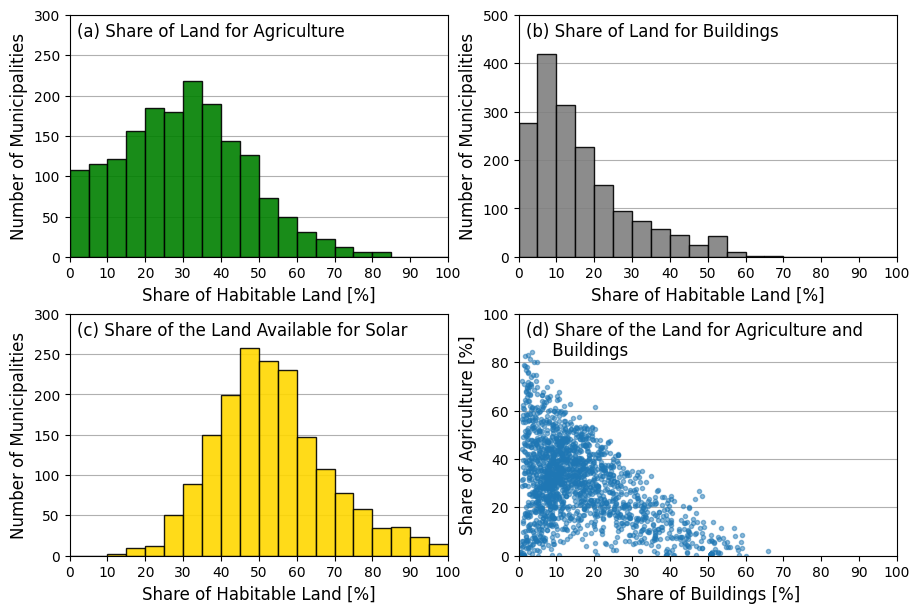

In [30]:
def set_common_attributes(
    ax, ylim=None, xlim=None, xticks=None, ylabel=None, xlabel=None
):
    ax.grid(which="both", axis="y", zorder=0)
    ax.set_axisbelow(True)

    if ylim is not None:
        ax.set_ylim(*ylim)
    if xlim is not None:
        ax.set_xlim(*xlim)
    if xticks is not None:
        ax.set_xticks(xticks)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=12)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=12)


def add_text(ax, text, loc=(0.02, 0.97), fontsize=12, verticalalignment="top"):
    ax.text(
        *loc,
        text,
        transform=ax.transAxes,
        fontsize=fontsize,
        verticalalignment=verticalalignment
    )

def plot_histogram(
    ax, data, bins, color, ylabel=None, xlabel=None, ylim=None, alpha=0.9
):
    n, bins, patches = ax.hist(
        data, bins=bins, edgecolor="black", color=color, alpha=alpha
    )
    set_common_attributes(
        ax,
        ylim=ylim,
        xlim=(0, 100),
        xticks=range(0, 101, 10),
        ylabel=ylabel,
        xlabel=xlabel,
    )
    return n, bins, patches


def plot_scatter(ax, df, x_col, y_col):
    df.plot(ax=ax, x=x_col, y=y_col, lw=0, marker=".", alpha=0.5)
    ax.legend().set_visible(False)
    set_common_attributes(
        ax,
        ylim=(0, 100),
        xlim=(0, 100),
        xticks=range(0, 101, 10),
        ylabel=y_col,
        xlabel=x_col,
    )


fig, axs = plt.subplots(2, 2)
axs = [item for sublist in axs for item in sublist]
fig.set_size_inches(9, 6)
plt.tight_layout(w_pad=2, h_pad=2)

# Plot Share of the Land for Agriculture
ax = axs[0]
plot_histogram(
    ax,
    land_ratio["land_agri"].values,
    bins=list(range(0, 101, 5)),
    color="green",
    ylabel="Number of Municipalities",
    xlabel="Share of Habitable Land [%]",
    ylim=(0, 300),
)
add_text(ax, "(a) Share of Land for Agriculture")



# Plot Share of the Land for Buildings
ax = axs[1]
plot_histogram(
    ax,
    land_ratio["land_buildings"].values,
    bins=list(range(0, 101, 5)),
    color="grey",
    ylabel="Number of Municipalities",
    xlabel="Share of Habitable Land [%]",
    ylim=(0, 500),
)
add_text(ax, "(b) Share of Land for Buildings")


# Plot Share of the Land Available for Solar
ax = axs[2]
plot_histogram(
    ax,
    land_ratio["land_avail"].values,
    bins=list(range(0, 101, 5)),
    color="gold",
    ylabel="Number of Municipalities",
    xlabel="Share of Habitable Land [%]",
    ylim=(0, 300),
)
add_text(ax, "(c) Share of the Land Available for Solar")

# Plot Share of the Land for Agriculture and Buildings
ax = axs[3]
plot_scatter(ax, land_ratio, "land_buildings", "land_agri")
add_text(ax, "(d) Share of the Land for Agriculture and\n     Buildings")
set_common_attributes(
    ax, ylabel="Share of Agriculture [%]", xlabel="Share of Buildings [%]"
)

savefig(fig, f"eda_land_distribution.svg")